# Stock_LSTM 

In this project, I perform a time series prediction using a  [Long Term Short Memory (LTSM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.

## Step 1: Loading the data

First let's load in our time series - a history of around 140 days of Apple's stock price. Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, it is good practice to normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).

In [1]:
### Load in necessary libraries for data input and normalization
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### load in and normalize the dataset
#dataset = np.loadtxt('data/normalized_apple_prices.csv')

In [2]:
# Import the yfinance. If you get module not found error the run !pip install yfiannce from your Jupyter notebook
import yfinance as yf
# Get the data of the stock AAPL
data_full = yf.download('TSLA','2016-01-01','2019-08-01')
dataset = data_full['Adj Close']

#normalize data
from sklearn import preprocessing
dataset = preprocessing.minmax_scale(dataset)



[*********************100%***********************]  1 of 1 completed


Lets take a quick look at the (normalized) time series we'll be performing predictions on.

Text(0, 0.5, 'normalized series value')

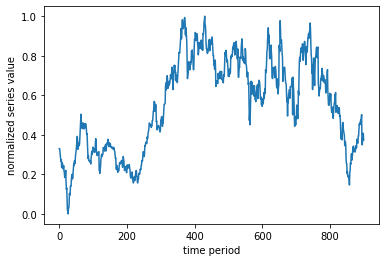

In [3]:
# lets take a look at our time series
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('normalized series value')

## Step 2:  Cutting our time series into sequences

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 4 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs.

Now let's window the input time series as described above!  

In [4]:
### The function below transforms the input series and window-size into a set of input/output pairs for our RNN model
def window_transform_series(series,window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    for i in range(window_size, len(series)):
        X.append(series[i - window_size:i])
        y.append(series[i])
        
        
    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    
    return X,y

In [5]:
# And now we can window the data using our windowing function
window_size = 100
X,y = window_transform_series(series = dataset,window_size = window_size)

## Step 3: Split training and testing sets

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [6]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(3*len(y)/float(4)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

## Step 4:  Build and run an RNN regression model

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used

In [7]:
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

epochs = 700

# start with fixed random seed
np.random.seed(0)


# Build an RNN to perform regression on our time series input/output data
model = Sequential()
model.add(LSTM(10, input_shape=(window_size, 1)))
model.add(Dense(1))


optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=1e-2/epochs)

# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

Using TensorFlow backend.


With our model built we are now ready to train the model below!

In [8]:
model.fit(X_train, y_train, epochs=epochs, batch_size=64, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/700
601/601 [==============================] - 1s 2ms/step - loss: 0.3185
Epoch 2/700
601/601 [==============================] - 1s 929us/step - loss: 0.1691
Epoch 3/700
601/601 [==============================] - 1s 895us/step - loss: 0.0812
Epoch 4/700
601/601 [==============================] - 1s 893us/step - loss: 0.0335 0s - loss:
Epoch 5/700
601/601 [==============================] - 1s 887us/step - loss: 0.0197
Epoch 6/700
601/601 [==============================] - 1s 835us/step - loss: 0.0146
Epoch 7/700
601/601 [==============================] - 1s 877us/step - loss: 0.0103
Epoch 8/700
601/601 [==============================] - 1s 927us/step - loss: 0.0074
Epoch 9/700
601/601 [==============================] - 1s 909us/step - loss: 0.0061
Epoch 10/700
601/601 [==============================] - 1s 919us/step - loss: 0.0054
Epoch 11/700
601/601 [==============================] 

601/601 [==============================] - 1s 900us/step - loss: 0.0012
Epoch 184/700
601/601 [==============================] - 1s 870us/step - loss: 0.0012
Epoch 185/700
601/601 [==============================] - 1s 898us/step - loss: 0.0012
Epoch 186/700
601/601 [==============================] - 1s 891us/step - loss: 0.0012
Epoch 187/700
601/601 [==============================] - 1s 870us/step - loss: 0.0012
Epoch 188/700
601/601 [==============================] - 1s 918us/step - loss: 0.0013
Epoch 189/700
601/601 [==============================] - 1s 857us/step - loss: 0.0013
Epoch 190/700
601/601 [==============================] - 1s 914us/step - loss: 0.0012
Epoch 191/700
601/601 [==============================] - 1s 853us/step - loss: 0.0012
Epoch 192/700
601/601 [==============================] - 1s 932us/step - loss: 0.0012
Epoch 193/700
601/601 [==============================] - 1s 908us/step - loss: 0.0011
Epoch 194/700
601/601 [==============================] - 1s 940us/st

601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 280/700
601/601 [==============================] - 1s 987us/step - loss: 0.0012
Epoch 281/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 282/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 283/700
601/601 [==============================] - 1s 942us/step - loss: 0.0012
Epoch 284/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 285/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 286/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 287/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 288/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 289/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 290/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Ep

601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 473/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 474/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 475/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 476/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 477/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 478/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 479/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 480/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 481/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 482/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 483/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 

601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 667/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 668/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 669/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 670/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 671/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 672/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 673/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 674/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 675/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 676/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0012
Epoch 677/700
601/601 [==============================] - 1s 1ms/step - loss: 0.0011
Epoch 

## Step 5: Checking model performance

With our model fit we can now make predictions on both our training and testing sets.

In [9]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [10]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.0011348934245982306
testing error = 0.0016285498626530171


Activating the next cell plots the original data, as well as both predictions on the training and testing sets. 

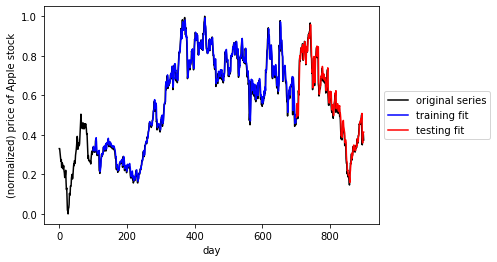

In [11]:
### Plot everything - the original series as well as predictions on training and testing sets
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

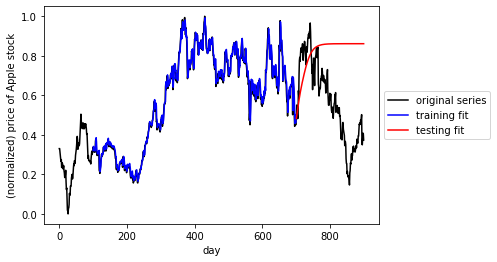

In [14]:
new_data = X_train[-2:-1]
#print(new_data)
pred_len = len(X_test)

test_predict = []

for i in range(pred_len):
    temp = model.predict(new_data)
    test_predict.append(temp)
    new_data=np.delete(new_data, 0)
    new_data = np.append(new_data,temp)
    new_data = np.asarray(np.reshape(new_data, (1, window_size, 1)))
    
#print(test_predict)
from itertools import chain
test_predict =list(chain(*test_predict))
# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('day')
plt.ylabel('(normalized) price of Apple stock')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()